In [1]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
#from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from glob import glob

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
K.set_image_data_format('channels_last')

In [3]:
data_path = sample.data_path()
print(data_path)

C:\Users\pesylvestre\mne_data\MNE-sample-data


In [4]:
pathdata = "C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data/"

In [5]:
gb = glob(pathdata+"sub-032*.csv")
print(gb)

['C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC1_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC2_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC3_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC4_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC5_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC6_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\\sub-032301_EC7_eeg.csv', 'C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc

In [6]:
#raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
#event_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
#tmin, tmax = -0., 1
event_id = dict(age_20_25 =1, age_25_30=2, age_30_35=3, age_35_40=4, age_55_60=5, age_60_65=6, age_65_70=7, age_70_75=8, age_75_80=9)

In [7]:
#raw = io.Raw(raw_fname, preload=True, verbose=False)
#raw.filter(2, None, method='iir')  # replace baselining with high-pass
#events = mne.read_events(event_fname)

In [8]:
#raw.info['bads'] = ['MEG 2443']  # set bad channels
#picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       #exclude='bads')

In [9]:
#epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    #picks=picks, baseline=None, preload=True, verbose=False)
#labels = epochs.events[:, -1]

In [10]:
#arr=np.zeros((len(gb),14501,63))

In [11]:
import csv
import numpy as np

In [12]:
arr=np.zeros((len(gb),63,14501))

In [13]:
import pandas as pd
i = 0
for filename in gb:
    print(filename, end="\r")
    df=pd.read_csv(filename)
    #print(df.values)
    #print(df.shape)
    if df.shape[0] == 14501:
        arr[i]=df.T.values
    i=i+1

#print(arr.shape, arr)

In [14]:
with open(pathdata+"clab.csv",'r') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ',',
                           quotechar = '"')
    data = [data for data in data_iter]
data_array = np.asarray(data[0][:-1]).astype(np.int)
print(data_array)
print(data_array.shape)

[7 7 7 ... 1 1 1]
(2438,)


C:\Users\PESYLV~1\AppData\Local\Temp/ipykernel_23272/4242893162.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_array = np.asarray(data[0][:-1]).astype(np.int)


In [15]:
X = arr[:]
y = data_array[:]
print(type(X))
print(y)
print(X.shape, y.shape)

<class 'numpy.ndarray'>
[7 7 7 ... 1 1 1]
(2438, 63, 14501) (2438,)


In [16]:
kernels, chans, samples = 1, 63, 14501
p50 = int(len(y)/2)
p75 = int(len(y)*0.75)

In [17]:
X_train      = X[0:p50,]
Y_train      = y[0:p50]
X_validate   = X[p50:p75,]
Y_validate   = y[p50:p75]
X_test       = X[p75:,]
Y_test       = y[p75:]

In [18]:
print(type(Y_train))
print(Y_train.shape)
print(Y_train)
Y_train      = np_utils.to_categorical(Y_train-1)
print(type(Y_train))
print(Y_train.shape)
print(Y_train)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

<class 'numpy.ndarray'>
(1219,)
[7 7 7 ... 1 2 2]
<class 'numpy.ndarray'>
(1219, 9)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [19]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(Y_train.shape[0], 'train samples')
print(Y_test.shape[0], 'test samples')

X_train shape: (1219, 63, 14501)
1219 train samples
610 test samples
1219 train samples
610 test samples


In [20]:
n_components = 2

In [21]:
clf = make_pipeline(XdawnCovariances(n_components, estimator='oas'),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

In [22]:
X_train = X_train.reshape(X_train.shape[0], chans, samples)
X_test = X_test.reshape(X_test.shape[0], chans, samples)

In [23]:
#print(X_train, Y_train.argmax(axis = -1))

In [24]:
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg = clf.predict(X_test)

c:\users\pesylvestre\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
acc2 = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2*100), end="")
print("%")

Classification accuracy: 20.491803 %


<Figure size 432x288 with 0 Axes>

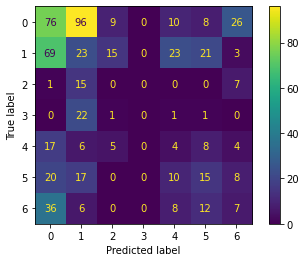

In [26]:
names = ['audio left', 'audio right', 'vis left', 'vis right']
plt.figure(0)
cm = confusion_matrix(Y_test.argmax(axis = -1), preds_rg)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [27]:
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_riemann
from pyriemann.classification import MDM
from sklearn.model_selection import cross_val_score

In [28]:
cvX = X_train[:100]
cvy = Y_train[:100]

In [31]:
print(X.shape, y.shape)

(100, 63, 14501) (100, 9)


In [32]:
y = data_array[:100]

In [33]:
pipe = make_pipeline(Covariances(), MDM())

# Entraînement et évaluation du modèle
scores = cross_val_score(pipe, cvX, cvy, cv=5)
print(scores.mean())

0.95


In [35]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.95 accuracy with a standard deviation of 0.06


In [34]:
y_pred = pipe.predict(X_test)

AttributeError: 'MDM' object has no attribute 'covmeans_'

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))